In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import scrublet as scr

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.0
pickleshare         0

In [2]:
fish390_1 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/390-1/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [3]:
fish390_1.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [4]:
fish390_1

AnnData object with n_obs × n_vars = 1754 × 25107
    var: 'gene_ids', 'feature_types'

In [5]:
sc.pp.filter_cells(fish390_1, min_genes=200)

In [6]:
fish390_1

AnnData object with n_obs × n_vars = 1754 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [7]:
mito_genes = fish390_1.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish390_1.obs['percent_mito'] = np.sum(
    fish390_1[:, mito_genes].X, axis=1).A1 / np.sum(fish390_1.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish390_1.obs['n_counts'] = fish390_1.X.sum(axis=1).A1
fish390_1.obs['log_counts'] = np.log(fish390_1.obs['n_counts'])
fish390_1.obs['n_genes'] = (fish390_1.X > 0).sum(1).A1
ribo_genes = fish390_1.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish390_1.obs['percent_ribo'] = np.sum(
    fish390_1[:, ribo_genes].X, axis=1).A1 / np.sum(fish390_1.X, axis=1).A1

In [8]:
fish390_1

AnnData object with n_obs × n_vars = 1754 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo'
    var: 'gene_ids', 'feature_types'

In [9]:
scrub = scr.Scrublet(fish390_1.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 8.4%
Estimated detectable doublet fraction = 51.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.4%
Elapsed time: 6.1 seconds


In [10]:
fish390_1.obs['scrublet_score'] = doublet_scores

In [11]:
fish390_1.obs['genotype'] = 'wildtype'
fish390_1.obs['Source'] = 'Nuclei'
fish390_1.obs['Region'] = 'ventricle'
fish390_1.obs['Sample_Number'] = '1'
fish390_1.obs['Sample'] = '390-1'

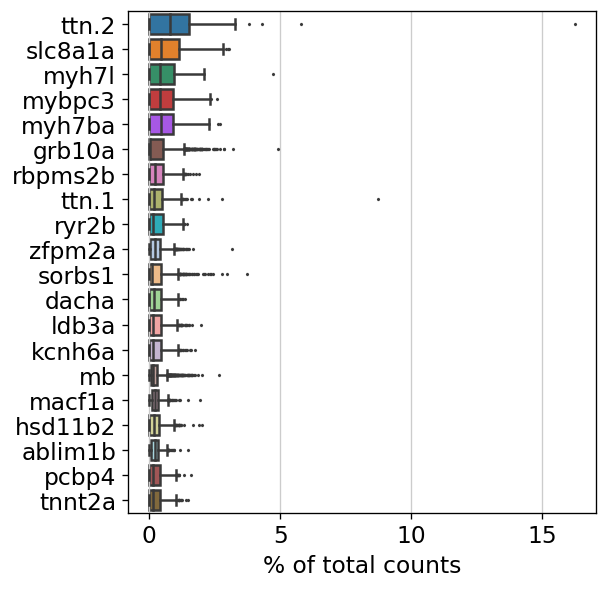

In [12]:
sc.pl.highest_expr_genes(fish390_1, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


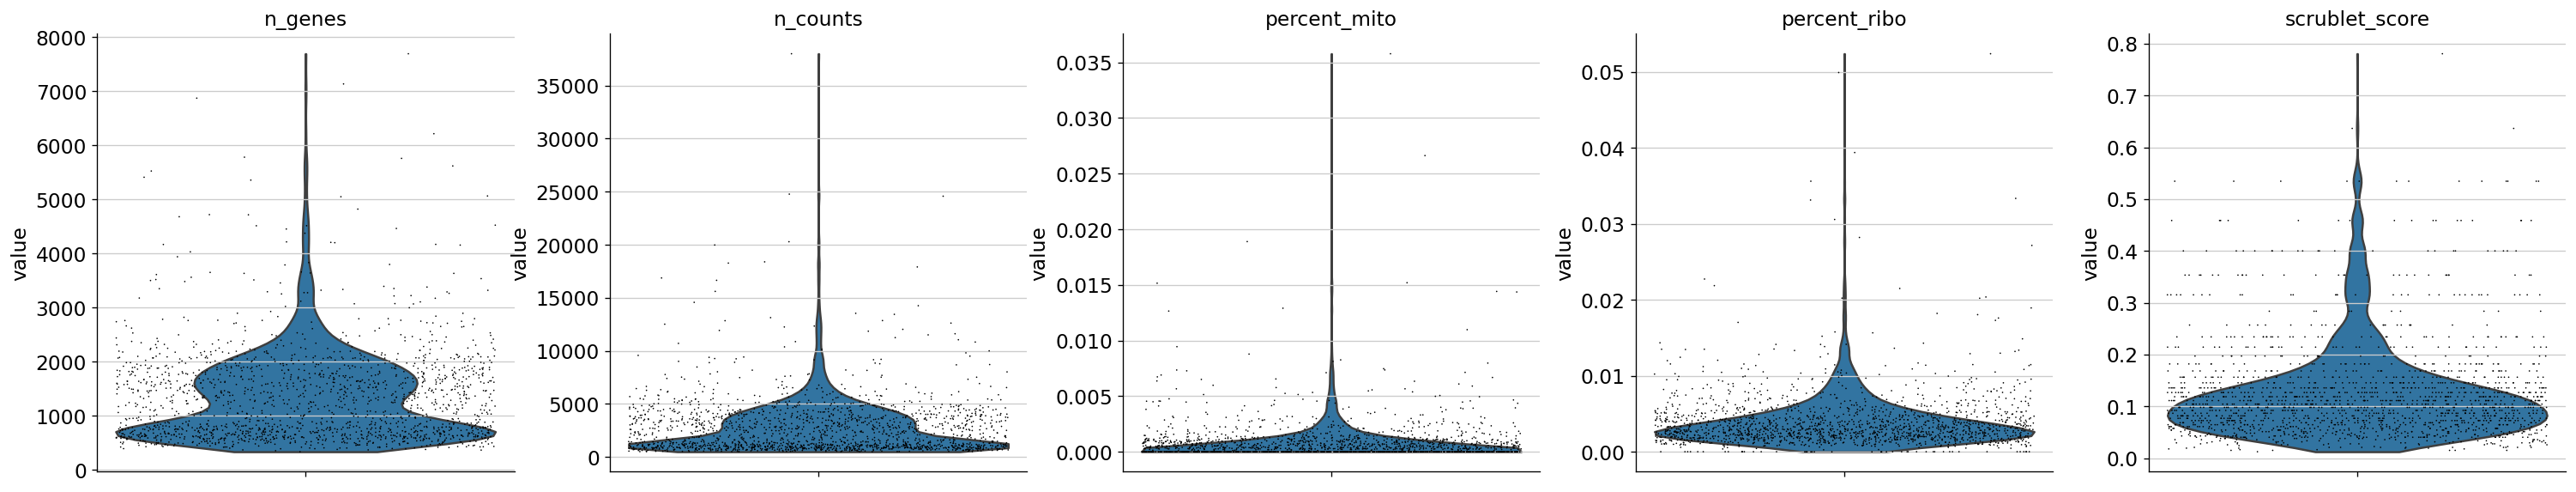

In [13]:
sc.pl.violin(fish390_1, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

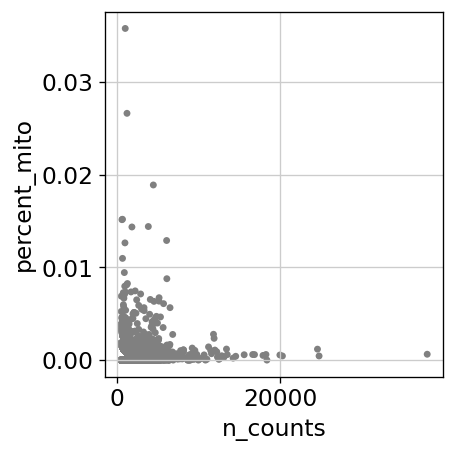

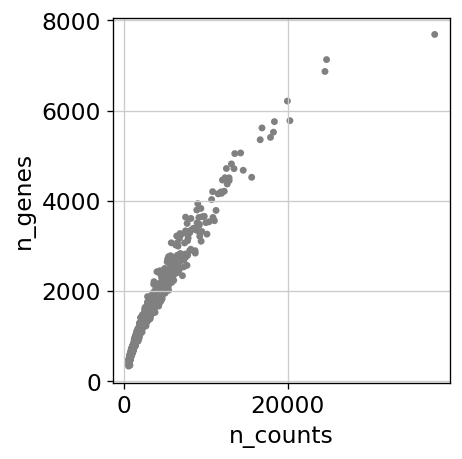

In [14]:
sc.pl.scatter(fish390_1, x='n_counts', y='percent_mito')
sc.pl.scatter(fish390_1, x='n_counts', y='n_genes')

In [15]:
fish390_1

AnnData object with n_obs × n_vars = 1754 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample'
    var: 'gene_ids', 'feature_types'

In [16]:
fish390_2 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/390-2/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [17]:
fish390_2.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [18]:
fish390_2

AnnData object with n_obs × n_vars = 1506 × 25107
    var: 'gene_ids', 'feature_types'

In [19]:
sc.pp.filter_cells(fish390_2, min_genes=200)

In [20]:
fish390_2

AnnData object with n_obs × n_vars = 1506 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [21]:
mito_genes = fish390_2.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish390_2.obs['percent_mito'] = np.sum(
    fish390_2[:, mito_genes].X, axis=1).A1 / np.sum(fish390_2.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish390_2.obs['n_counts'] = fish390_2.X.sum(axis=1).A1
fish390_2.obs['log_counts'] = np.log(fish390_2.obs['n_counts'])
fish390_2.obs['n_genes'] = (fish390_2.X > 0).sum(1).A1
ribo_genes = fish390_2.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish390_2.obs['percent_ribo'] = np.sum(
    fish390_2[:, ribo_genes].X, axis=1).A1 / np.sum(fish390_2.X, axis=1).A1

In [22]:
scrub = scr.Scrublet(fish390_2.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 2.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.6%
Elapsed time: 1.8 seconds


In [23]:
fish390_2.obs['scrublet_score'] = doublet_scores

In [24]:
fish390_2.obs['genotype'] = 'wildtype'
fish390_2.obs['Source'] = 'Nuclei'
fish390_2.obs['Region'] = 'ventricle'
fish390_2.obs['Sample_Number'] = '2'
fish390_2.obs['Sample'] = '390-2'

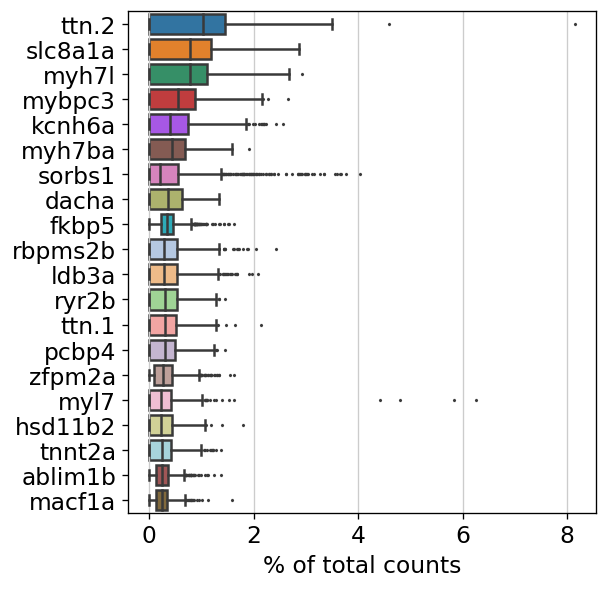

In [25]:
sc.pl.highest_expr_genes(fish390_2, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


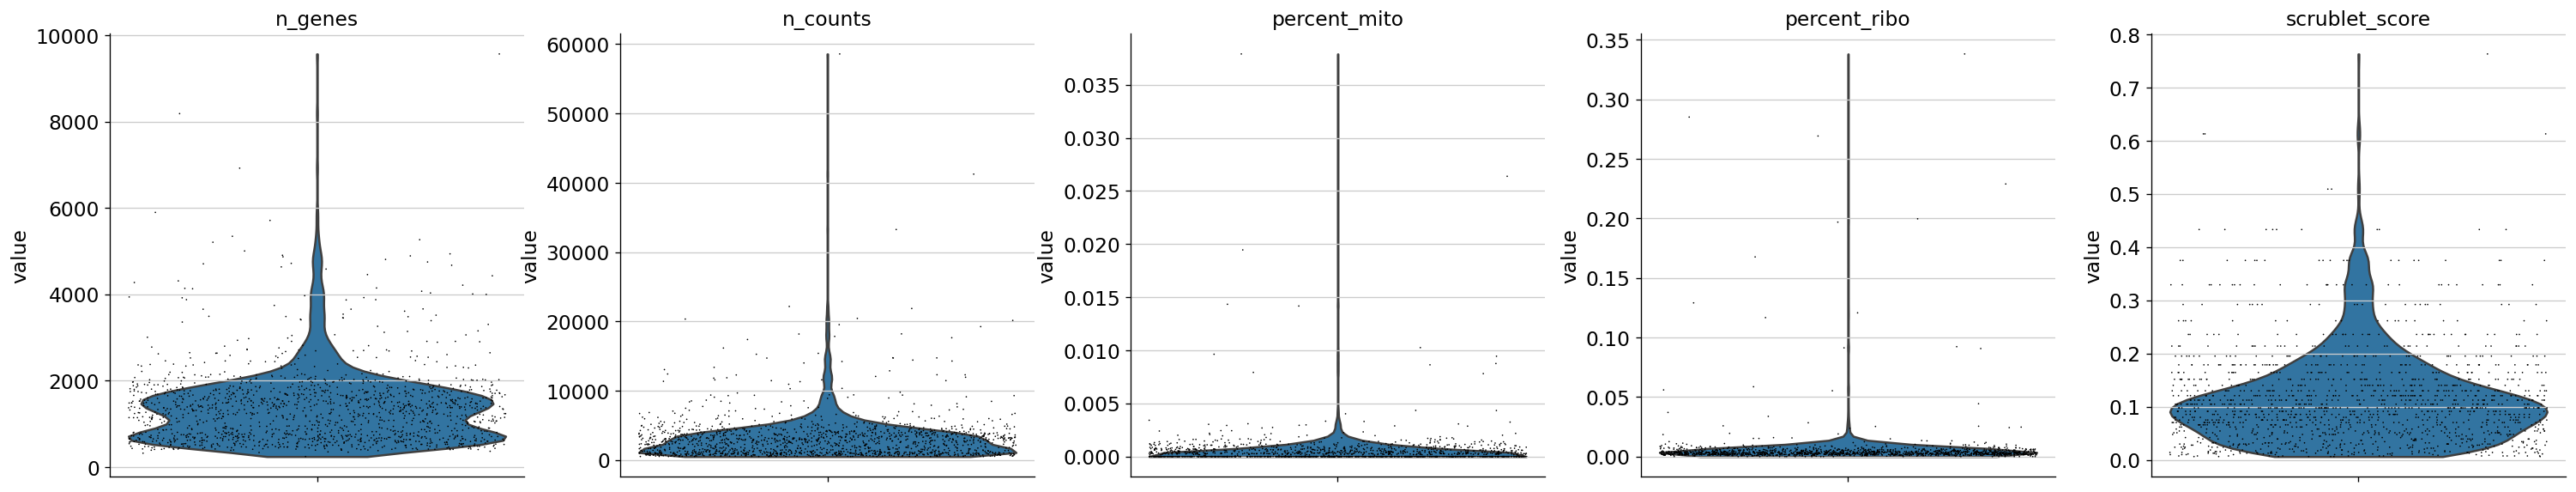

In [26]:
sc.pl.violin(fish390_2, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

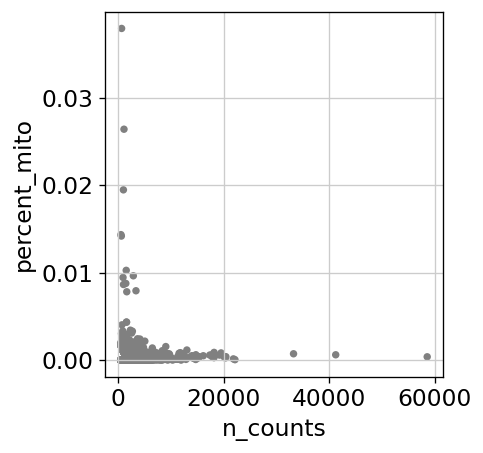

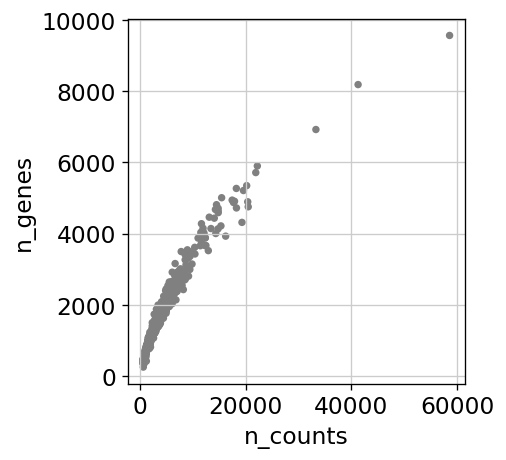

In [27]:
sc.pl.scatter(fish390_2, x='n_counts', y='percent_mito')
sc.pl.scatter(fish390_2, x='n_counts', y='n_genes')

In [28]:
fish390_2

AnnData object with n_obs × n_vars = 1506 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample'
    var: 'gene_ids', 'feature_types'

In [29]:
fish390_3 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/390-3/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [30]:
fish390_3.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [31]:
fish390_3

AnnData object with n_obs × n_vars = 1361 × 25107
    var: 'gene_ids', 'feature_types'

In [32]:
sc.pp.filter_cells(fish390_3, min_genes=200)

In [33]:
fish390_3

AnnData object with n_obs × n_vars = 1361 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [34]:
mito_genes = fish390_3.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish390_3.obs['percent_mito'] = np.sum(
    fish390_3[:, mito_genes].X, axis=1).A1 / np.sum(fish390_3.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish390_3.obs['n_counts'] = fish390_3.X.sum(axis=1).A1
fish390_3.obs['log_counts'] = np.log(fish390_3.obs['n_counts'])
fish390_3.obs['n_genes'] = (fish390_3.X > 0).sum(1).A1
ribo_genes = fish390_3.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish390_3.obs['percent_ribo'] = np.sum(
    fish390_3[:, ribo_genes].X, axis=1).A1 / np.sum(fish390_3.X, axis=1).A1


In [35]:
scrub = scr.Scrublet(fish390_3.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 1.6 seconds


In [36]:
fish390_3.obs['scrublet_score'] = doublet_scores

In [37]:
fish390_3.obs['genotype'] = 'wildtype'
fish390_3.obs['Source'] = 'Nuclei'
fish390_3.obs['Region'] = 'ventricle'
fish390_3.obs['Sample_Number'] = '3'
fish390_3.obs['Sample'] = '390-3'

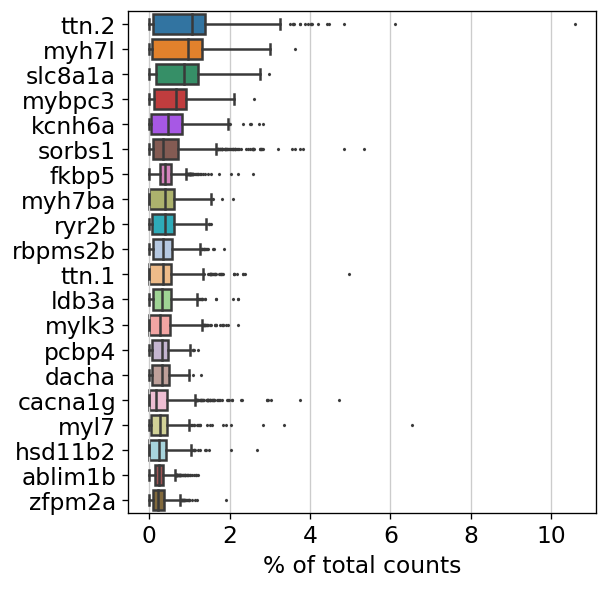

In [38]:
sc.pl.highest_expr_genes(fish390_3, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


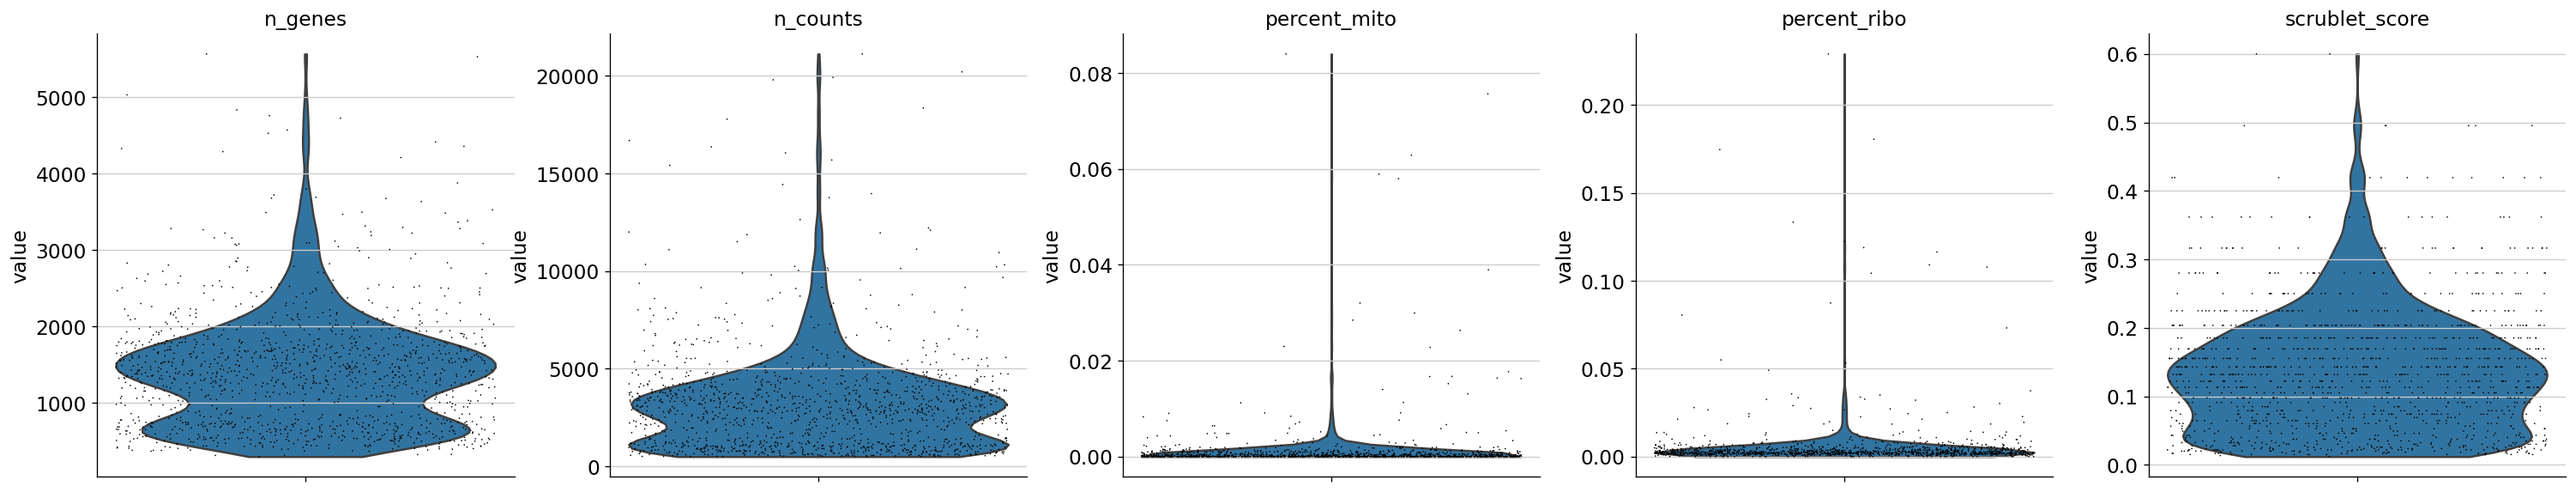

In [39]:
sc.pl.violin(fish390_3, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

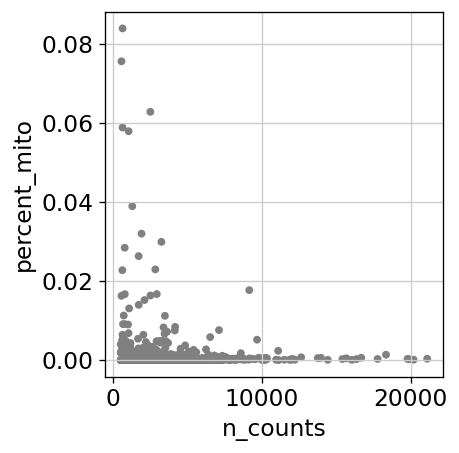

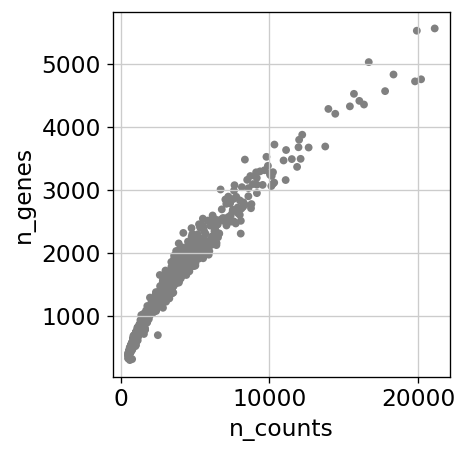

In [40]:
sc.pl.scatter(fish390_3, x='n_counts', y='percent_mito')
sc.pl.scatter(fish390_3, x='n_counts', y='n_genes')

In [41]:
fish391_1 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/391-1/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [42]:
fish391_1.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [43]:
fish391_1

AnnData object with n_obs × n_vars = 1468 × 25107
    var: 'gene_ids', 'feature_types'

In [44]:
sc.pp.filter_cells(fish391_1, min_genes=200)

In [45]:
fish391_1

AnnData object with n_obs × n_vars = 1468 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [46]:
mito_genes = fish391_1.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish391_1.obs['percent_mito'] = np.sum(
    fish391_1[:, mito_genes].X, axis=1).A1 / np.sum(fish391_1.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish391_1.obs['n_counts'] = fish391_1.X.sum(axis=1).A1
fish391_1.obs['log_counts'] = np.log(fish391_1.obs['n_counts'])
fish391_1.obs['n_genes'] = (fish391_1.X > 0).sum(1).A1
ribo_genes = fish391_1.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish391_1.obs['percent_ribo'] = np.sum(
    fish391_1[:, ribo_genes].X, axis=1).A1 / np.sum(fish391_1.X, axis=1).A1

In [47]:
scrub = scr.Scrublet(fish391_1.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 42.1%
Elapsed time: 1.8 seconds


In [48]:
fish391_1.obs['scrublet_score'] = doublet_scores

In [49]:
fish391_1.obs['genotype'] = 'popdc1 null'
fish391_1.obs['Source'] = 'Nuclei'
fish391_1.obs['Region'] = 'ventricle'
fish391_1.obs['Sample_Number'] = '1'
fish391_1.obs['Sample'] = '391-1'

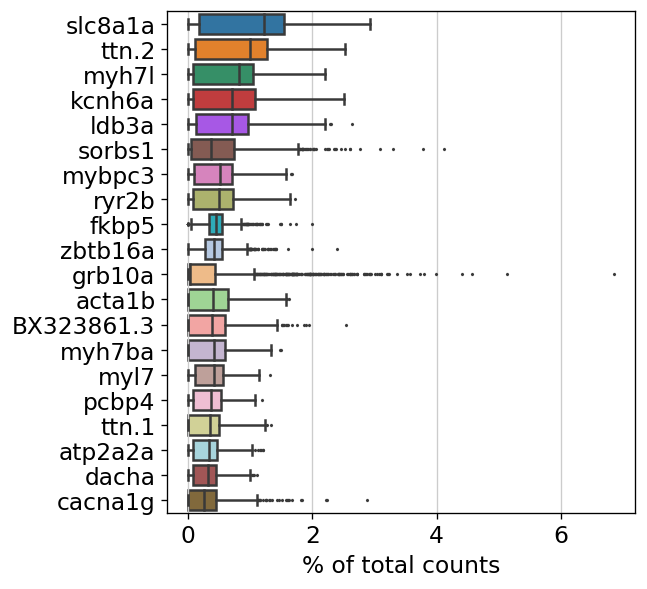

In [50]:
sc.pl.highest_expr_genes(fish391_1, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


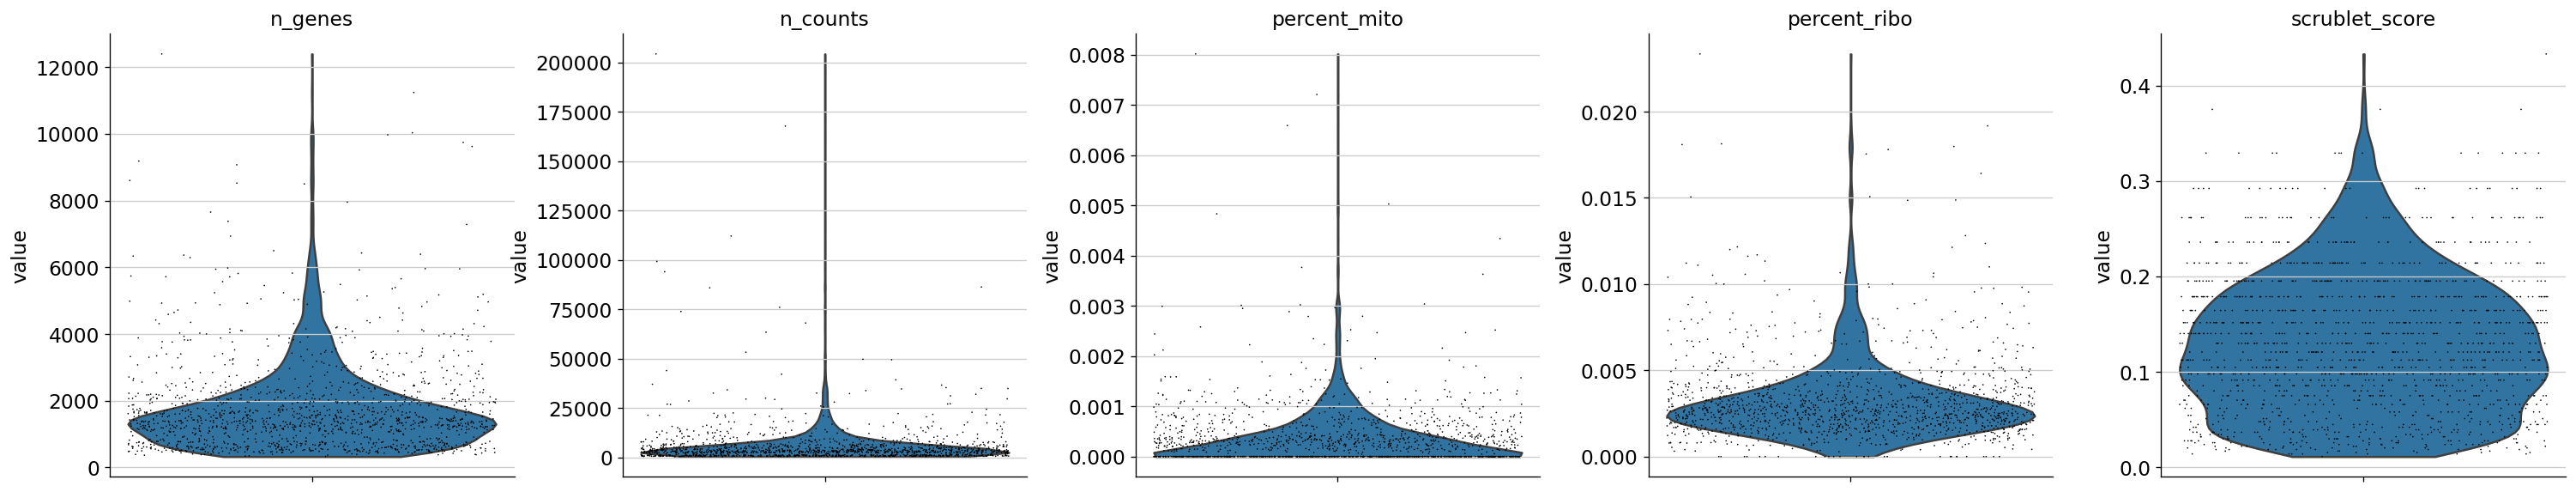

In [51]:
sc.pl.violin(fish391_1, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

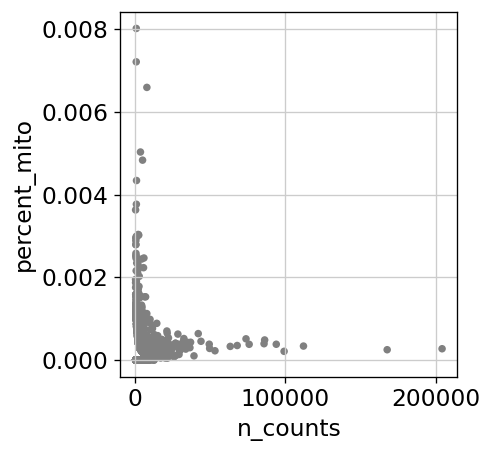

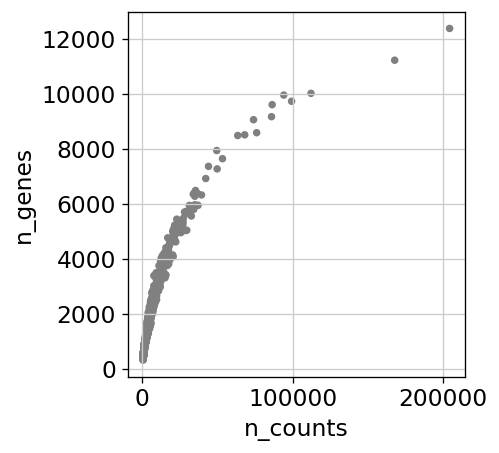

In [52]:
sc.pl.scatter(fish391_1, x='n_counts', y='percent_mito')
sc.pl.scatter(fish391_1, x='n_counts', y='n_genes')

In [53]:
fish391_1

AnnData object with n_obs × n_vars = 1468 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample'
    var: 'gene_ids', 'feature_types'

In [54]:
fish391_2 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/391-2/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [55]:
fish391_2.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [56]:
fish391_2

AnnData object with n_obs × n_vars = 1339 × 25107
    var: 'gene_ids', 'feature_types'

In [57]:
sc.pp.filter_cells(fish391_2, min_genes=200)

In [58]:
fish391_2

AnnData object with n_obs × n_vars = 1339 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [59]:
mito_genes = fish391_2.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish391_2.obs['percent_mito'] = np.sum(
    fish391_2[:, mito_genes].X, axis=1).A1 / np.sum(fish391_2.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish391_2.obs['n_counts'] = fish391_2.X.sum(axis=1).A1
fish391_2.obs['log_counts'] = np.log(fish391_2.obs['n_counts'])
fish391_2.obs['n_genes'] = (fish391_2.X > 0).sum(1).A1
ribo_genes = fish391_2.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish391_2.obs['percent_ribo'] = np.sum(
    fish391_2[:, ribo_genes].X, axis=1).A1 / np.sum(fish391_2.X, axis=1).A1

In [60]:
scrub = scr.Scrublet(fish391_2.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.6 seconds


In [61]:
fish391_2.obs['scrublet_score'] = doublet_scores

In [62]:
fish391_2.obs['genotype'] = 'popdc1 null'
fish391_2.obs['Source'] = 'Nuclei'
fish391_2.obs['Region'] = 'ventricle'
fish391_2.obs['Sample_Number'] = '2'
fish391_2.obs['Sample'] = '391-2'

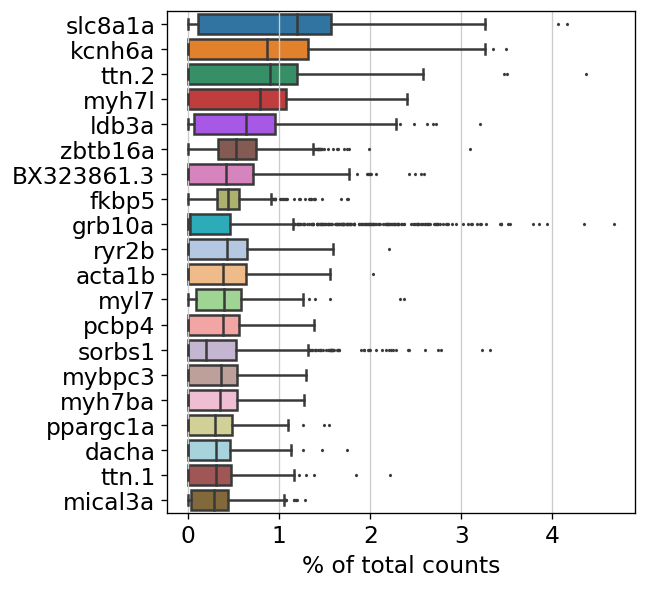

In [63]:
sc.pl.highest_expr_genes(fish391_2, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


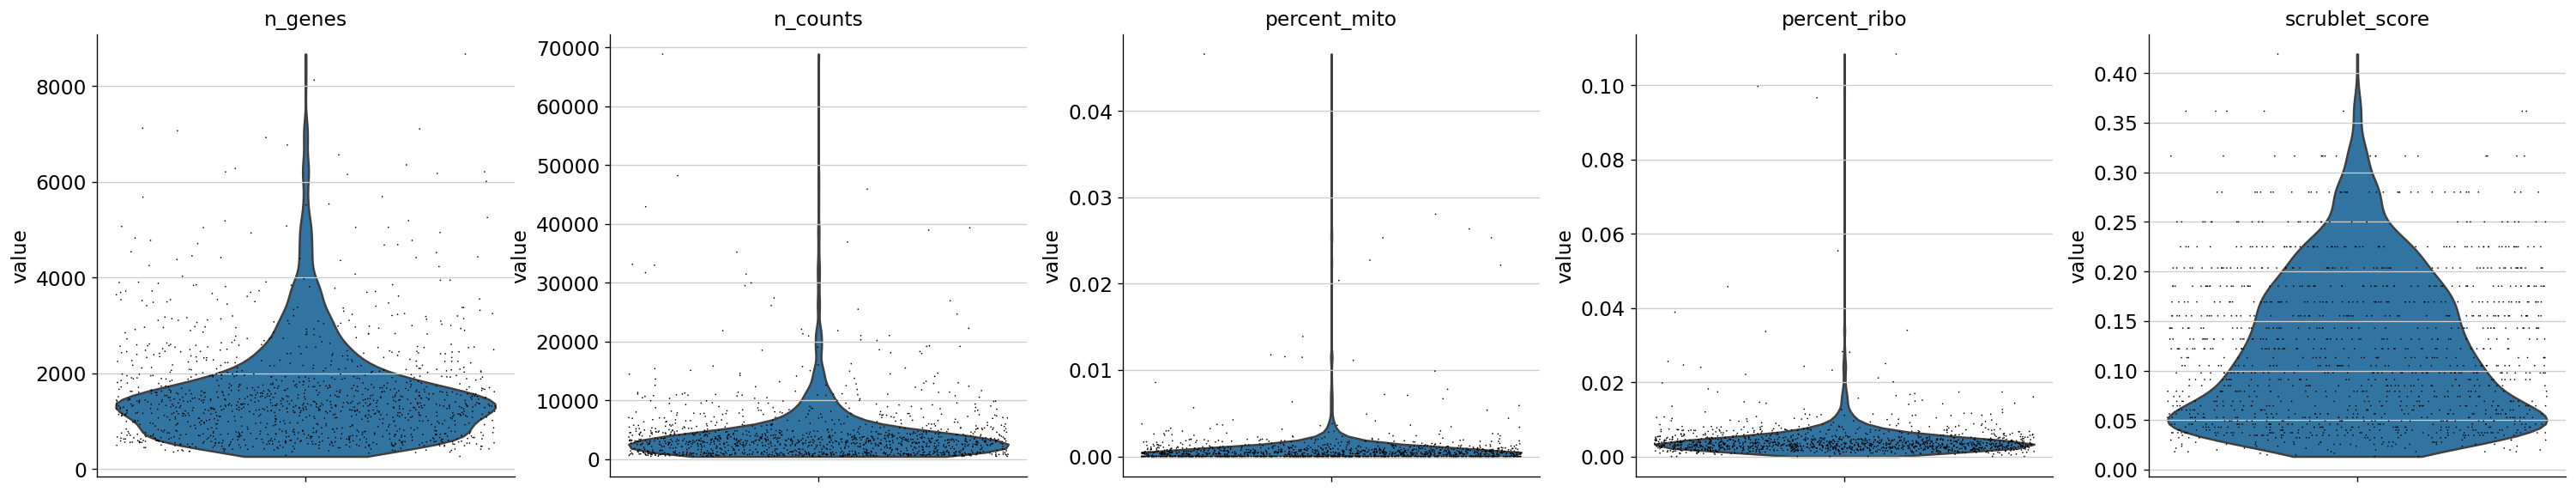

In [64]:
sc.pl.violin(fish391_2, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

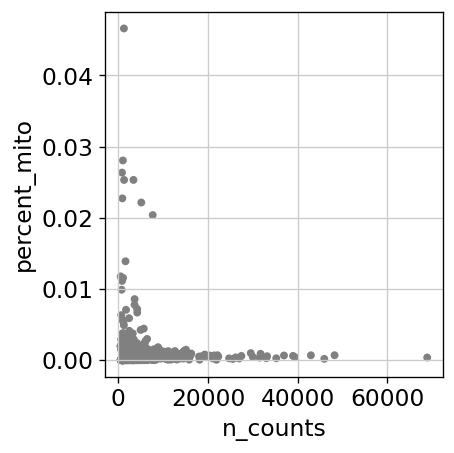

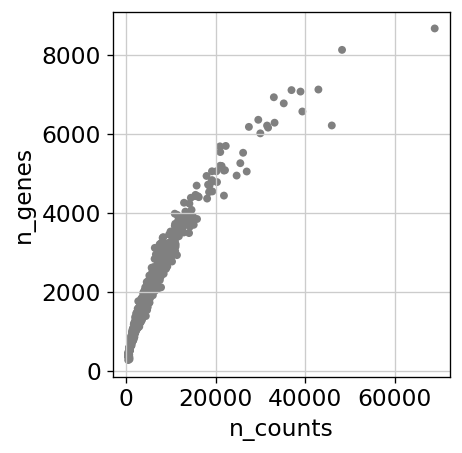

In [65]:
sc.pl.scatter(fish391_2, x='n_counts', y='percent_mito')
sc.pl.scatter(fish391_2, x='n_counts', y='n_genes')

In [66]:
fish391_3 = sc.read_10x_mtx(
    '/rds/general/user/lb616/projects/popdc1/live/zfish_ven/zfish_ven_cell_ranger_counts/391-3/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [67]:
fish391_3.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [68]:
fish391_3

AnnData object with n_obs × n_vars = 1110 × 25107
    var: 'gene_ids', 'feature_types'

In [69]:
sc.pp.filter_cells(fish391_3, min_genes=200)

In [70]:
fish391_3

AnnData object with n_obs × n_vars = 1110 × 25107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types'

In [71]:
mito_genes = fish391_3.var_names.str.startswith('mt-') # Seaches for all genes that start with 'MT-'
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
fish391_3.obs['percent_mito'] = np.sum(
    fish391_3[:, mito_genes].X, axis=1).A1 / np.sum(fish391_3.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
fish391_3.obs['n_counts'] = fish391_3.X.sum(axis=1).A1
fish391_3.obs['log_counts'] = np.log(fish391_3.obs['n_counts'])
fish391_3.obs['n_genes'] = (fish391_3.X > 0).sum(1).A1
ribo_genes = fish391_3.var_names.str.startswith(('rps','rpl')) # Seaches for all genes that start with 'RPS' or 'RPL'
fish391_3.obs['percent_ribo'] = np.sum(
    fish391_3[:, ribo_genes].X, axis=1).A1 / np.sum(fish391_3.X, axis=1).A1

In [72]:
scrub = scr.Scrublet(fish391_3.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 3.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.7%
Elapsed time: 1.2 seconds


In [73]:
fish391_3.obs['scrublet_score'] = doublet_scores

In [74]:
fish391_3.obs['genotype'] = 'popdc1 null'
fish391_3.obs['Source'] = 'Nuclei'
fish391_3.obs['Region'] = 'ventricle'
fish391_3.obs['Sample_Number'] = '3'
fish391_3.obs['Sample'] = '391-3'

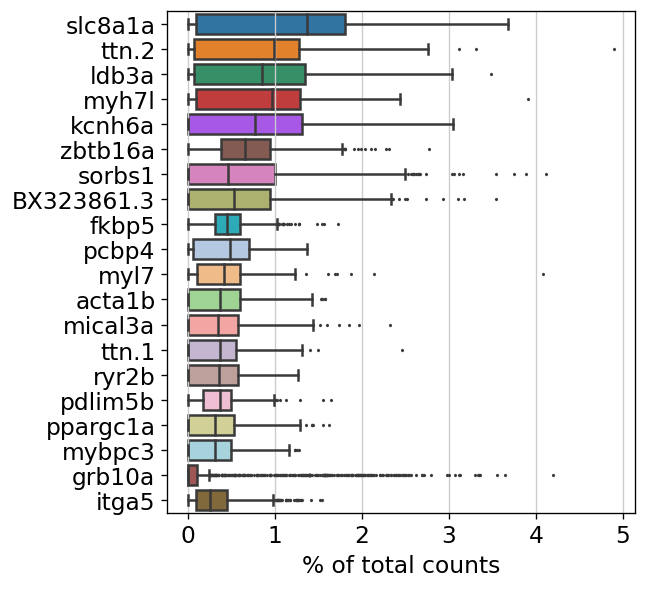

In [75]:
sc.pl.highest_expr_genes(fish391_3, n_top=20)

... storing 'genotype' as categorical
... storing 'Source' as categorical
... storing 'Region' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical
... storing 'feature_types' as categorical


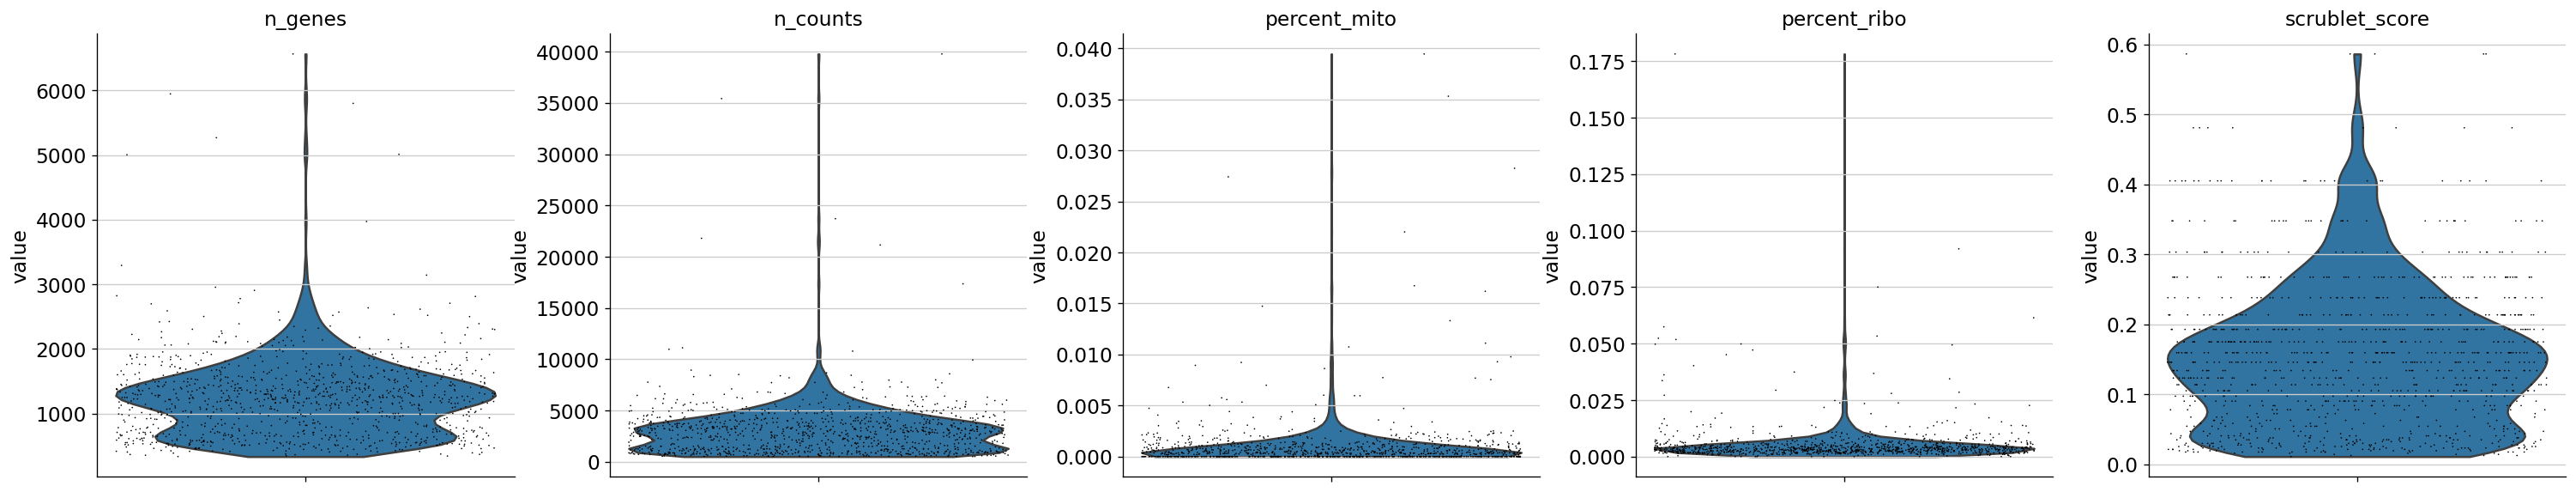

In [76]:
sc.pl.violin(fish391_3, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.4, multi_panel=True)

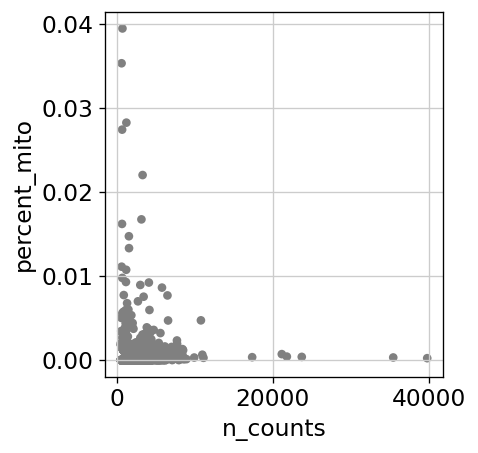

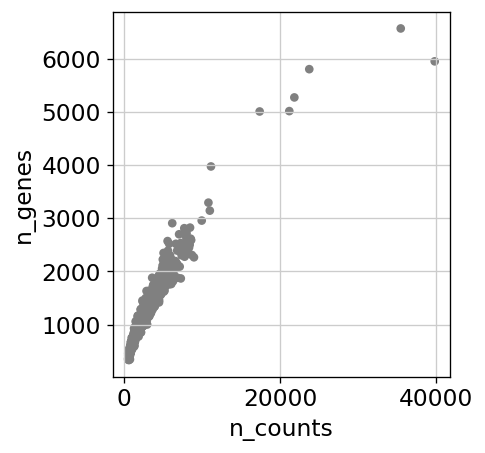

In [77]:
sc.pl.scatter(fish391_3, x='n_counts', y='percent_mito')
sc.pl.scatter(fish391_3, x='n_counts', y='n_genes')

In [78]:
fish391_3

AnnData object with n_obs × n_vars = 1110 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample'
    var: 'gene_ids', 'feature_types'

In [79]:
# You can merge multiple samples at once by adding them at the start of the function. More info can be found here https://anndata.readthedocs.io/en/latest/anndata.AnnData.concatenate.html
# eg. adata_merged = anndata.AnnData.concatenate(sample1, sample2, sample3, sample4, join = 'outer')
fish390_merged = anndata.AnnData.concatenate(fish390_1, fish390_2, fish390_3, join = 'outer')

In [80]:
fish390_merged.obs

n_genes  percent_mito  n_counts  log_counts  \
AAACGAACAGGAACCA-1-0     1315      0.003315    2715.0    7.906547   
AAACGAATCTGCTGAA-1-0     1387      0.000000    2664.0    7.887584   
AAACGCTCAGTCAGCC-1-0     2271      0.000200    4990.0    8.515191   
AAACGCTTCGCCTTTG-1-0     2214      0.000000    4727.0    8.461046   
AAAGAACTCGCCGTGA-1-0     1668      0.000595    3364.0    8.120886   
...                       ...           ...       ...         ...   
TTTGGTTCAGTCAACT-1-2     3283      0.000586   10242.0    9.234252   
TTTGGTTGTGCTCGTG-1-2      950      0.000000    1893.0    7.545918   
TTTGGTTTCGAGAAAT-1-2     2248      0.000458    6545.0    8.786457   
TTTGTTGTCACGGTCG-1-2     1758      0.000241    4152.0    8.331346   
TTTGTTGTCCATCTGC-1-2     2019      0.000177    5654.0    8.640119   

                      percent_ribo  scrublet_score  genotype  Source  \
AAACGAACAGGAACCA-1-0      0.004052        0.118557  wildtype  Nuclei   
AAACGAATCTGCTGAA-1-0      0.003003        0.068392  wildtype  Nuclei   
AAACGCTCAGTCAGCC-1-0      0.001804        0.400000  wildtype  Nuclei   
AAACGCTTCGCCTTTG-1-0      0.002116        0.400000  wildtype  Nuclei   
AAAGAACTCGCCGTGA-1-0      0.002973        0.097950  wildtype  Nuclei   
...                            ...             ...       ...     ...   
TTTGGTTCAGTCAACT-1-2      0.001855        0.361702  wildtype  Nuclei   
TTTGGTTGTGCTCGTG-1-2      0.004754        0.121951  wildtype  Nuclei   
TTTGGTTTCGAGAAAT-1-2      0.001833        0.142857  wildtype  Nuclei   
TTTGTTGTCACGGTCG-1-2      0.001686        0.155235  wildtype  Nuclei   
TTTGTTGTCCATCTGC-1-2      0.001769        0.203540  wildtype  Nuclei   

                         Region Sample_Number Sample batch  
AAACGAACAGGAACCA-1-0  ventricle             1  390-1     0  
AAACGAATCTGCTGAA-1-0  ventricle             1  390-1     0  
AAACGCTCAGTCAGCC-1-0  ventricle             1  390-1     0  
AAACGCTTCGCCTTTG-1-0  ventricle             1  390-1     0  
AAAGAACTCGCCGTGA-1-0  ventricle             1  390-1     0  
...                         ...           ...    ...   ...  
TTTGGTTCAGTCAACT-1-2  ventricle             3  390-3     2  
TTTGGTTGTGCTCGTG-1-2  ventricle             3  390-3     2  
TTTGGTTTCGAGAAAT-1-2  ventricle             3  390-3     2  
TTTGTTGTCACGGTCG-1-2  ventricle             3  390-3     2  
TTTGTTGTCCATCTGC-1-2  ventricle             3  390-3     2  

[4621 rows x 12 columns]

In [81]:
fish390_merged

AnnData object with n_obs × n_vars = 4621 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [82]:
# Save the unfiltered merged anndata object to .h5ad file
fish390_merged.write('./fish390_merged_unfiltered.h5ad')

... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical


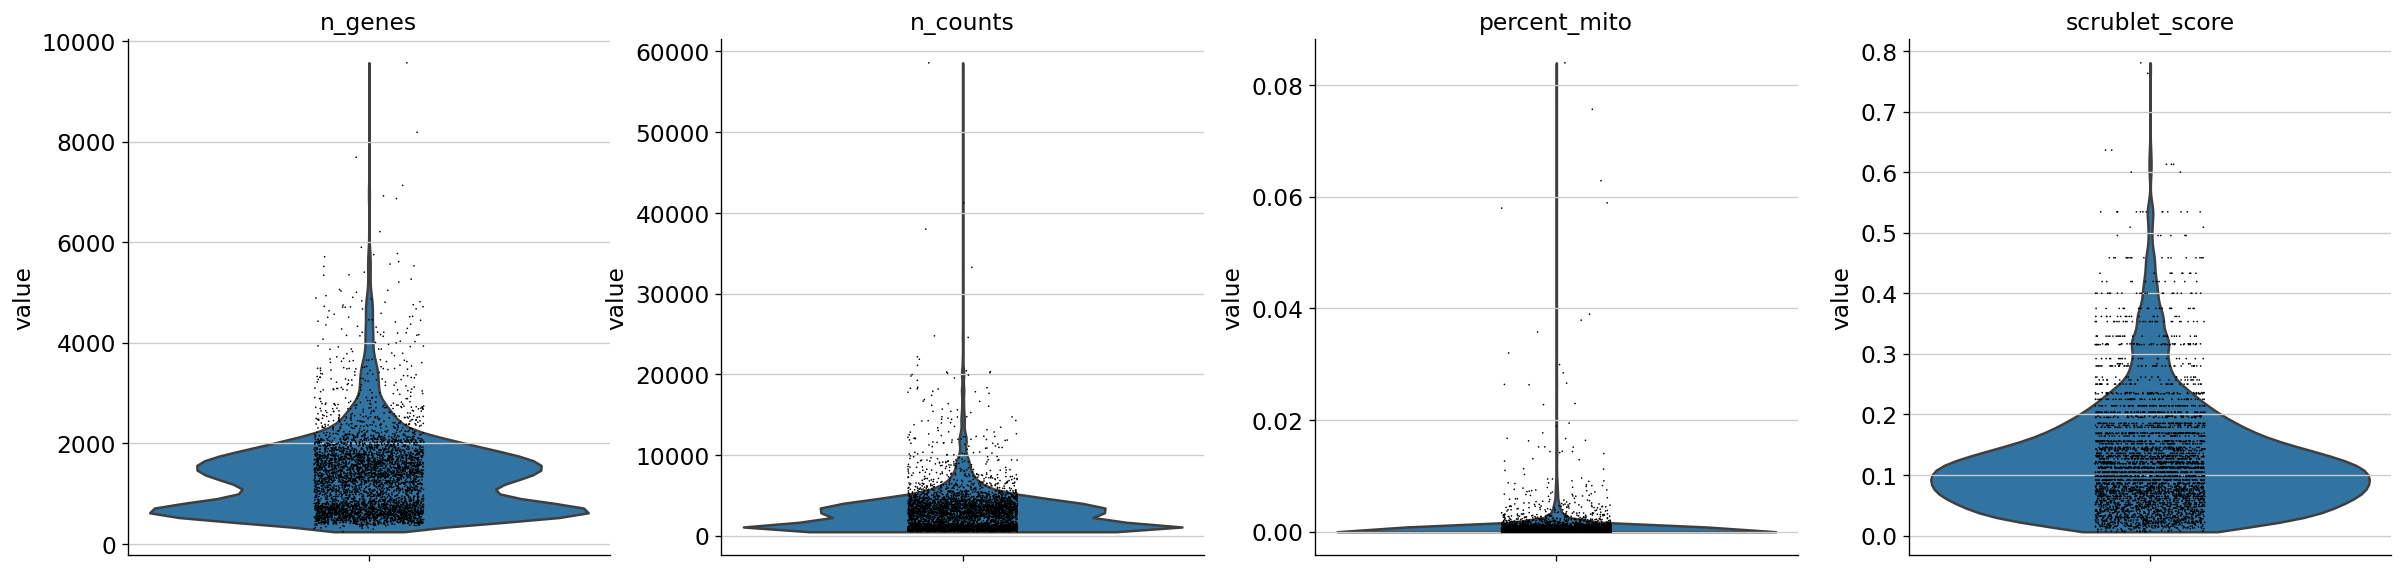

In [83]:
sc.pl.violin(fish390_merged, ['n_genes', 'n_counts', 'percent_mito', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [84]:
# You can merge multiple samples at once by adding them at the start of the function. More info can be found here https://anndata.readthedocs.io/en/latest/anndata.AnnData.concatenate.html
# eg. adata_merged = anndata.AnnData.concatenate(sample1, sample2, sample3, sample4, join = 'outer')
fish391_merged = anndata.AnnData.concatenate(fish391_1, fish391_2, fish391_3, join = 'outer')

In [85]:
fish391_merged.obs

n_genes  percent_mito  n_counts  log_counts  \
AAACCCAAGTGGTCAG-1-0      848      0.000000    1353.0    7.210080   
AAACCCATCACTGAAC-1-0     3287      0.000405    9873.0    9.197559   
AAACGCTGTAACAGTA-1-0     1418      0.000272    3674.0    8.209036   
AAACGCTTCACCCATC-1-0     1657      0.001252    3994.0    8.292548   
AAAGGATAGACTCCGC-1-0     1068      0.001723    2322.0    7.750184   
...                       ...           ...       ...         ...   
TTTCATGCAGGTTCCG-1-2     2136      0.000601    6658.0    8.803575   
TTTCCTCGTGCACATT-1-2      538      0.000000     819.0    6.708084   
TTTCCTCTCAAGCCCG-1-2     1109      0.001183    2536.0    7.838343   
TTTGATCCATGGGTCC-1-2      708      0.000000    1000.0    6.907755   
TTTGTTGAGTAGACAT-1-2     1798      0.000783    5109.0    8.538759   

                      percent_ribo  scrublet_score     genotype  Source  \
AAACCCAAGTGGTCAG-1-0      0.001478        0.097744  popdc1 null  Nuclei   
AAACCCATCACTGAAC-1-0      0.003342        0.213974  popdc1 null  Nuclei   
AAACGCTGTAACAGTA-1-0      0.001633        0.129909  popdc1 null  Nuclei   
AAACGCTTCACCCATC-1-0      0.002504        0.120690  popdc1 null  Nuclei   
AAAGGATAGACTCCGC-1-0      0.003015        0.054348  popdc1 null  Nuclei   
...                            ...             ...          ...     ...   
TTTCATGCAGGTTCCG-1-2      0.004205        0.134021  popdc1 null  Nuclei   
TTTCCTCGTGCACATT-1-2      0.006105        0.035176  popdc1 null  Nuclei   
TTTCCTCTCAAGCCCG-1-2      0.003549        0.067568  popdc1 null  Nuclei   
TTTGATCCATGGGTCC-1-2      0.003000        0.213592  popdc1 null  Nuclei   
TTTGTTGAGTAGACAT-1-2      0.003132        0.267442  popdc1 null  Nuclei   

                         Region Sample_Number Sample batch  
AAACCCAAGTGGTCAG-1-0  ventricle             1  391-1     0  
AAACCCATCACTGAAC-1-0  ventricle             1  391-1     0  
AAACGCTGTAACAGTA-1-0  ventricle             1  391-1     0  
AAACGCTTCACCCATC-1-0  ventricle             1  391-1     0  
AAAGGATAGACTCCGC-1-0  ventricle             1  391-1     0  
...                         ...           ...    ...   ...  
TTTCATGCAGGTTCCG-1-2  ventricle             3  391-3     2  
TTTCCTCGTGCACATT-1-2  ventricle             3  391-3     2  
TTTCCTCTCAAGCCCG-1-2  ventricle             3  391-3     2  
TTTGATCCATGGGTCC-1-2  ventricle             3  391-3     2  
TTTGTTGAGTAGACAT-1-2  ventricle             3  391-3     2  

[3917 rows x 12 columns]

In [86]:
fish391_merged

AnnData object with n_obs × n_vars = 3917 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [87]:
# Save the unfiltered merged anndata object to .h5ad file
fish391_merged.write('./fish391_merged_unfiltered.h5ad')

... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical


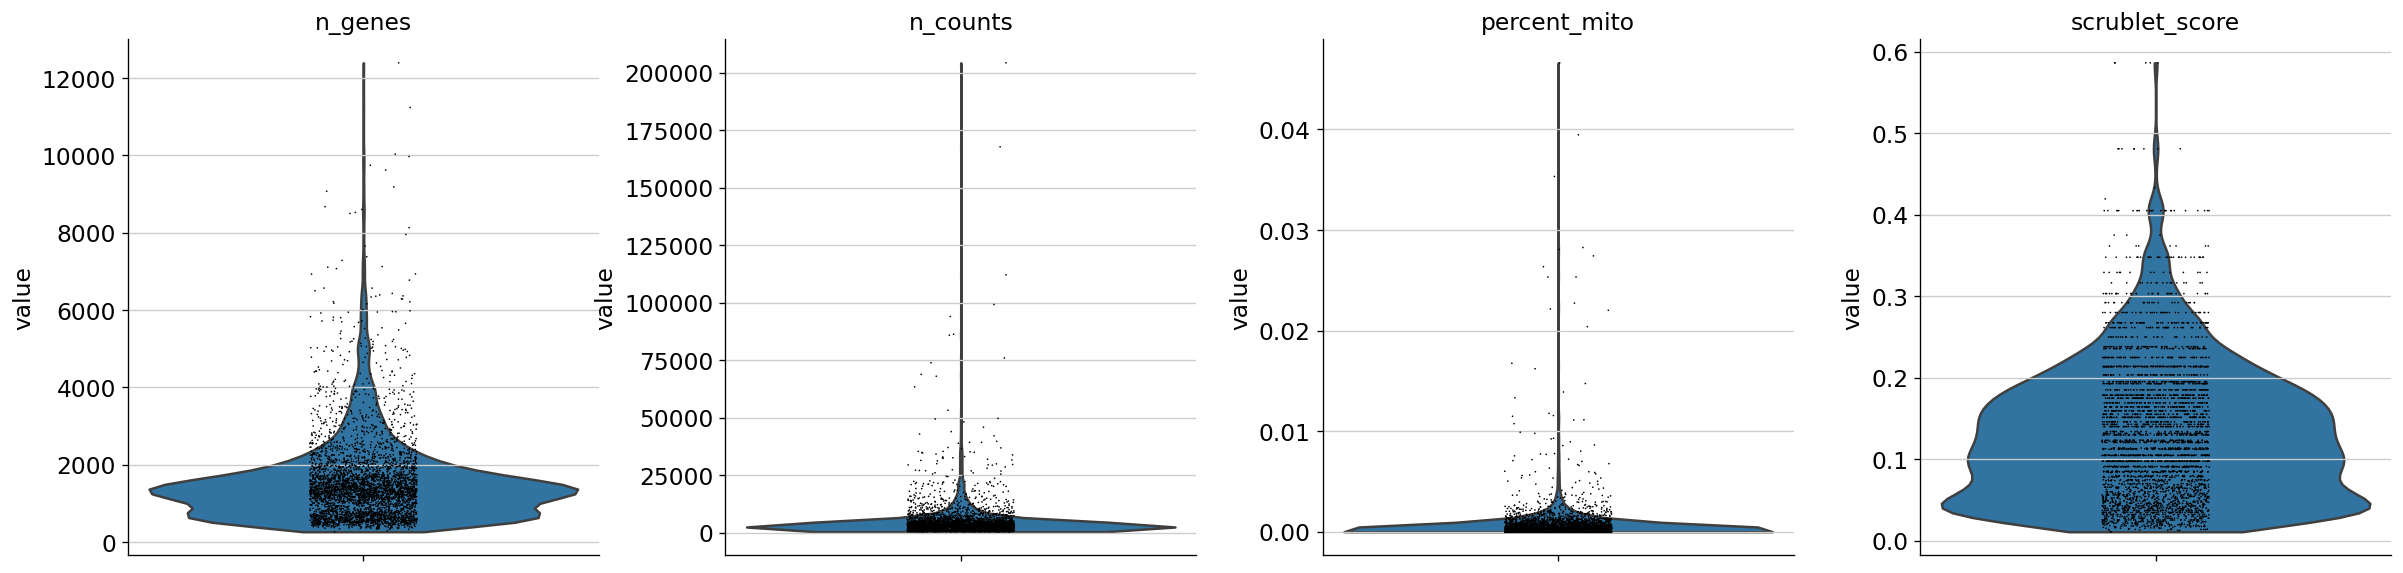

In [88]:
sc.pl.violin(fish391_merged, ['n_genes', 'n_counts', 'percent_mito', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [89]:
# You can merge multiple samples at once by adding them at the start of the function. More info can be found here https://anndata.readthedocs.io/en/latest/anndata.AnnData.concatenate.html
# eg. adata_merged = anndata.AnnData.concatenate(sample1, sample2, sample3, sample4, join = 'outer')
fish_ven_merged = anndata.AnnData.concatenate(fish391_1, fish391_2, fish391_3, fish390_1, fish390_2, fish390_3, join = 'outer')

In [90]:
fish_ven_merged.obs

n_genes  percent_mito  n_counts  log_counts  \
AAACCCAAGTGGTCAG-1-0      848      0.000000    1353.0    7.210080   
AAACCCATCACTGAAC-1-0     3287      0.000405    9873.0    9.197559   
AAACGCTGTAACAGTA-1-0     1418      0.000272    3674.0    8.209036   
AAACGCTTCACCCATC-1-0     1657      0.001252    3994.0    8.292548   
AAAGGATAGACTCCGC-1-0     1068      0.001723    2322.0    7.750184   
...                       ...           ...       ...         ...   
TTTGGTTCAGTCAACT-1-5     3283      0.000586   10242.0    9.234252   
TTTGGTTGTGCTCGTG-1-5      950      0.000000    1893.0    7.545918   
TTTGGTTTCGAGAAAT-1-5     2248      0.000458    6545.0    8.786457   
TTTGTTGTCACGGTCG-1-5     1758      0.000241    4152.0    8.331346   
TTTGTTGTCCATCTGC-1-5     2019      0.000177    5654.0    8.640119   

                      percent_ribo  scrublet_score     genotype  Source  \
AAACCCAAGTGGTCAG-1-0      0.001478        0.097744  popdc1 null  Nuclei   
AAACCCATCACTGAAC-1-0      0.003342        0.213974  popdc1 null  Nuclei   
AAACGCTGTAACAGTA-1-0      0.001633        0.129909  popdc1 null  Nuclei   
AAACGCTTCACCCATC-1-0      0.002504        0.120690  popdc1 null  Nuclei   
AAAGGATAGACTCCGC-1-0      0.003015        0.054348  popdc1 null  Nuclei   
...                            ...             ...          ...     ...   
TTTGGTTCAGTCAACT-1-5      0.001855        0.361702     wildtype  Nuclei   
TTTGGTTGTGCTCGTG-1-5      0.004754        0.121951     wildtype  Nuclei   
TTTGGTTTCGAGAAAT-1-5      0.001833        0.142857     wildtype  Nuclei   
TTTGTTGTCACGGTCG-1-5      0.001686        0.155235     wildtype  Nuclei   
TTTGTTGTCCATCTGC-1-5      0.001769        0.203540     wildtype  Nuclei   

                         Region Sample_Number Sample batch  
AAACCCAAGTGGTCAG-1-0  ventricle             1  391-1     0  
AAACCCATCACTGAAC-1-0  ventricle             1  391-1     0  
AAACGCTGTAACAGTA-1-0  ventricle             1  391-1     0  
AAACGCTTCACCCATC-1-0  ventricle             1  391-1     0  
AAAGGATAGACTCCGC-1-0  ventricle             1  391-1     0  
...                         ...           ...    ...   ...  
TTTGGTTCAGTCAACT-1-5  ventricle             3  390-3     5  
TTTGGTTGTGCTCGTG-1-5  ventricle             3  390-3     5  
TTTGGTTTCGAGAAAT-1-5  ventricle             3  390-3     5  
TTTGTTGTCACGGTCG-1-5  ventricle             3  390-3     5  
TTTGTTGTCCATCTGC-1-5  ventricle             3  390-3     5  

[8538 rows x 12 columns]

In [91]:
fish_ven_merged

AnnData object with n_obs × n_vars = 8538 × 25107
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [92]:
# Save the unfiltered merged anndata object to .h5ad file
fish_ven_merged.write('./fish_ven_merged_unfiltered.h5ad')

... storing 'genotype' as categorical
... storing 'Sample_Number' as categorical
... storing 'Sample' as categorical


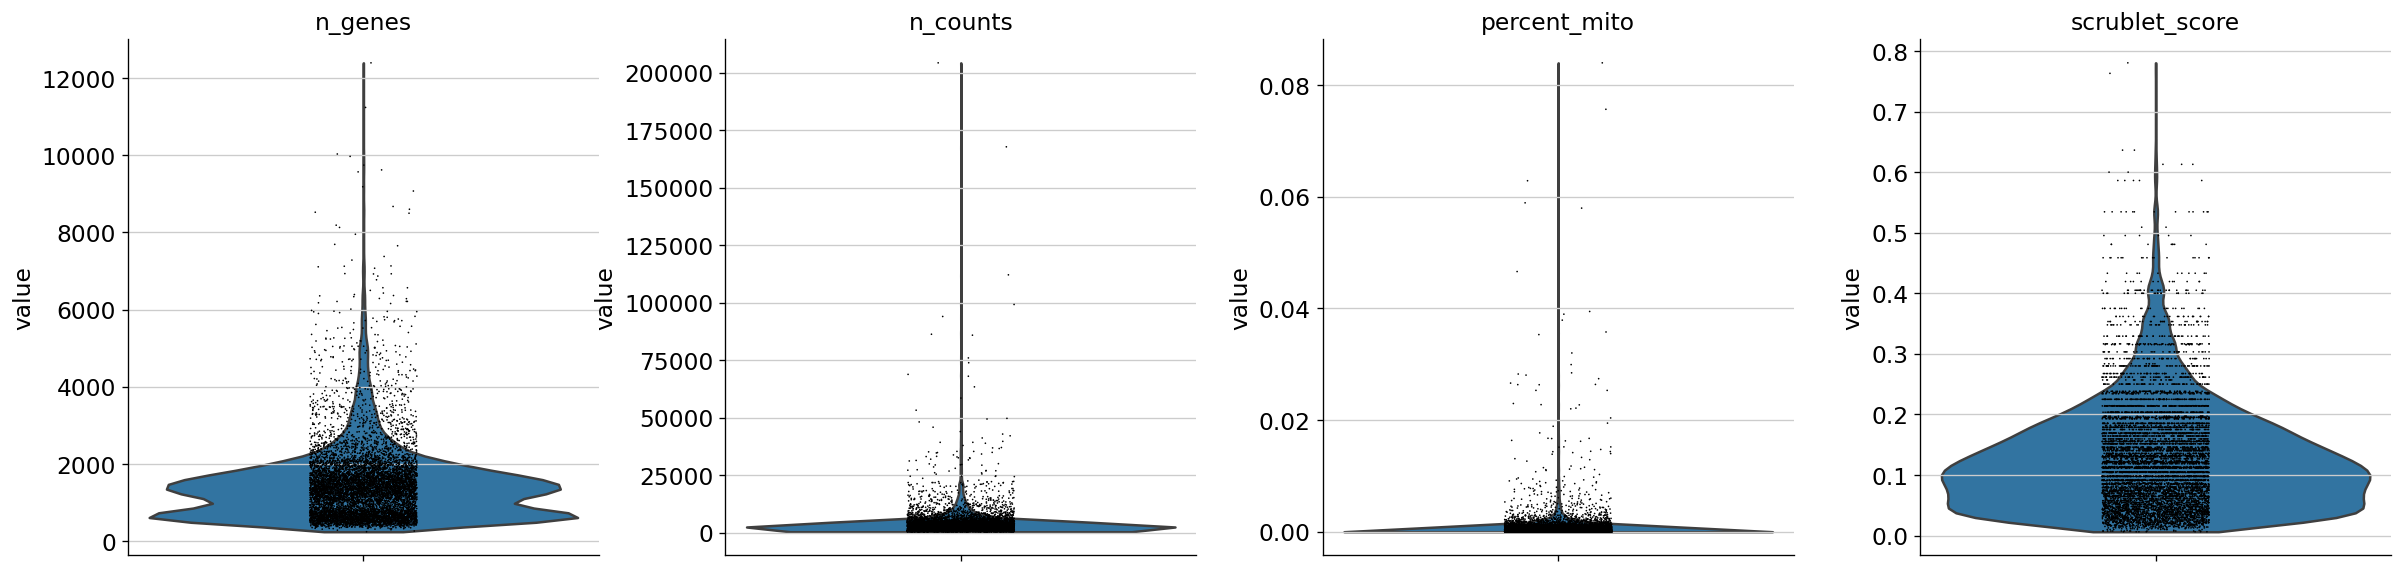

In [93]:
sc.pl.violin(fish_ven_merged, ['n_genes', 'n_counts', 'percent_mito', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [94]:
fish_ven_merged_filtered = fish_ven_merged.copy()
# Filter by UMI counts
sc.pp.filter_cells(fish_ven_merged_filtered, min_counts=500)
sc.pp.filter_cells(fish_ven_merged_filtered, max_counts=7500)

# Filter by number of genes expressed
sc.pp.filter_cells(fish_ven_merged_filtered, min_genes=300)
sc.pp.filter_cells(fish_ven_merged_filtered, max_genes=2500)

# Filter by %mitochondrial genes, %ribosomal genes, and scublet score (doublet probability)
fish_ven_merged_filtered = fish_ven_merged_filtered[fish_ven_merged_filtered.obs.percent_mito < 0.05, :]
fish_ven_merged_filtered = fish_ven_merged_filtered[fish_ven_merged_filtered.obs.percent_ribo < 0.05, :]
fish_ven_merged_filtered = fish_ven_merged_filtered[fish_ven_merged_filtered.obs.scrublet_score < 0.30, :]

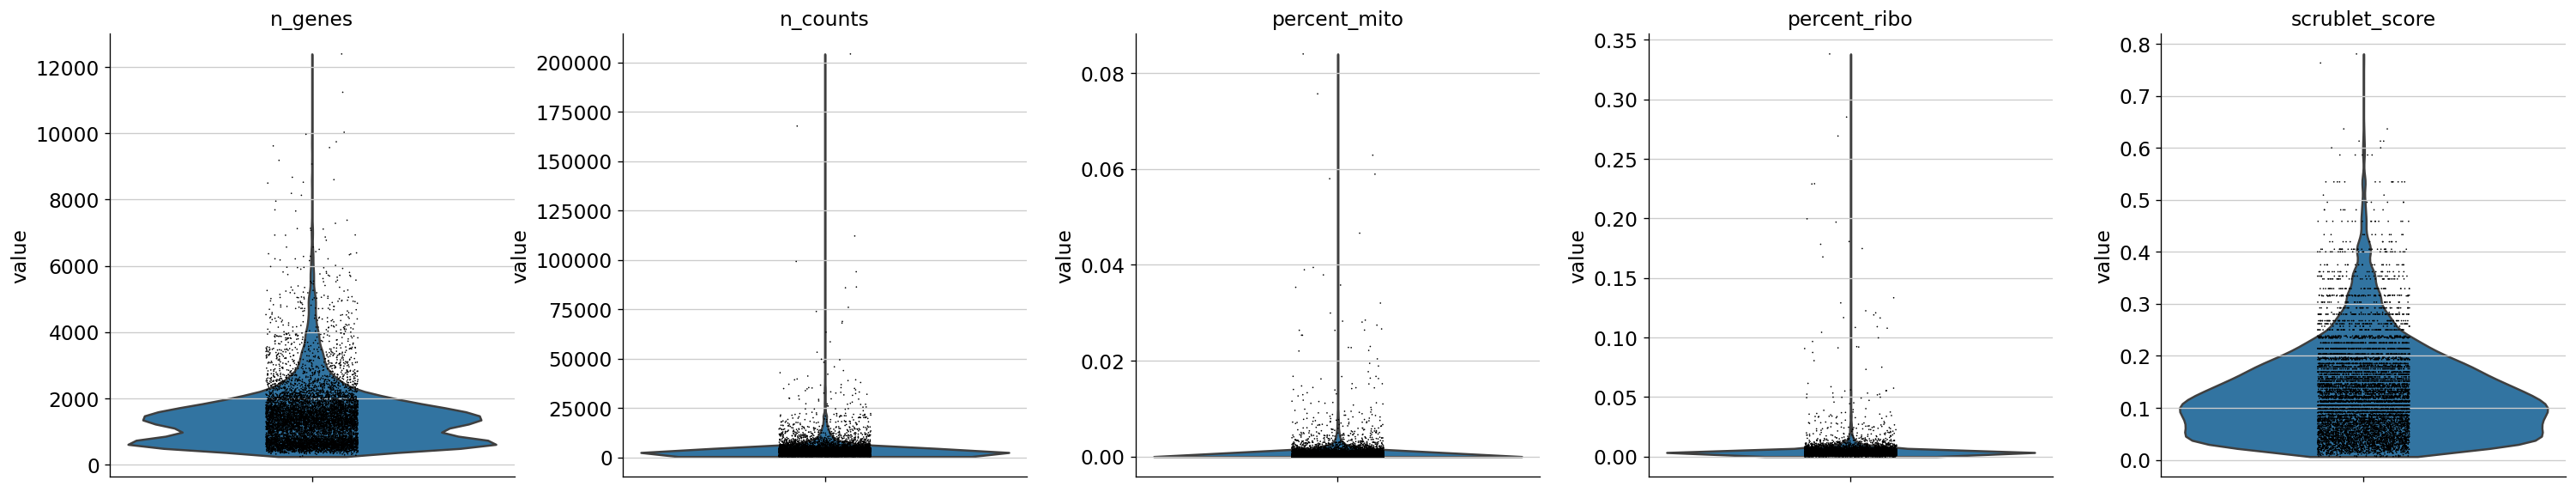

In [95]:
# QC plots before filtering
sc.pl.violin(fish_ven_merged, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

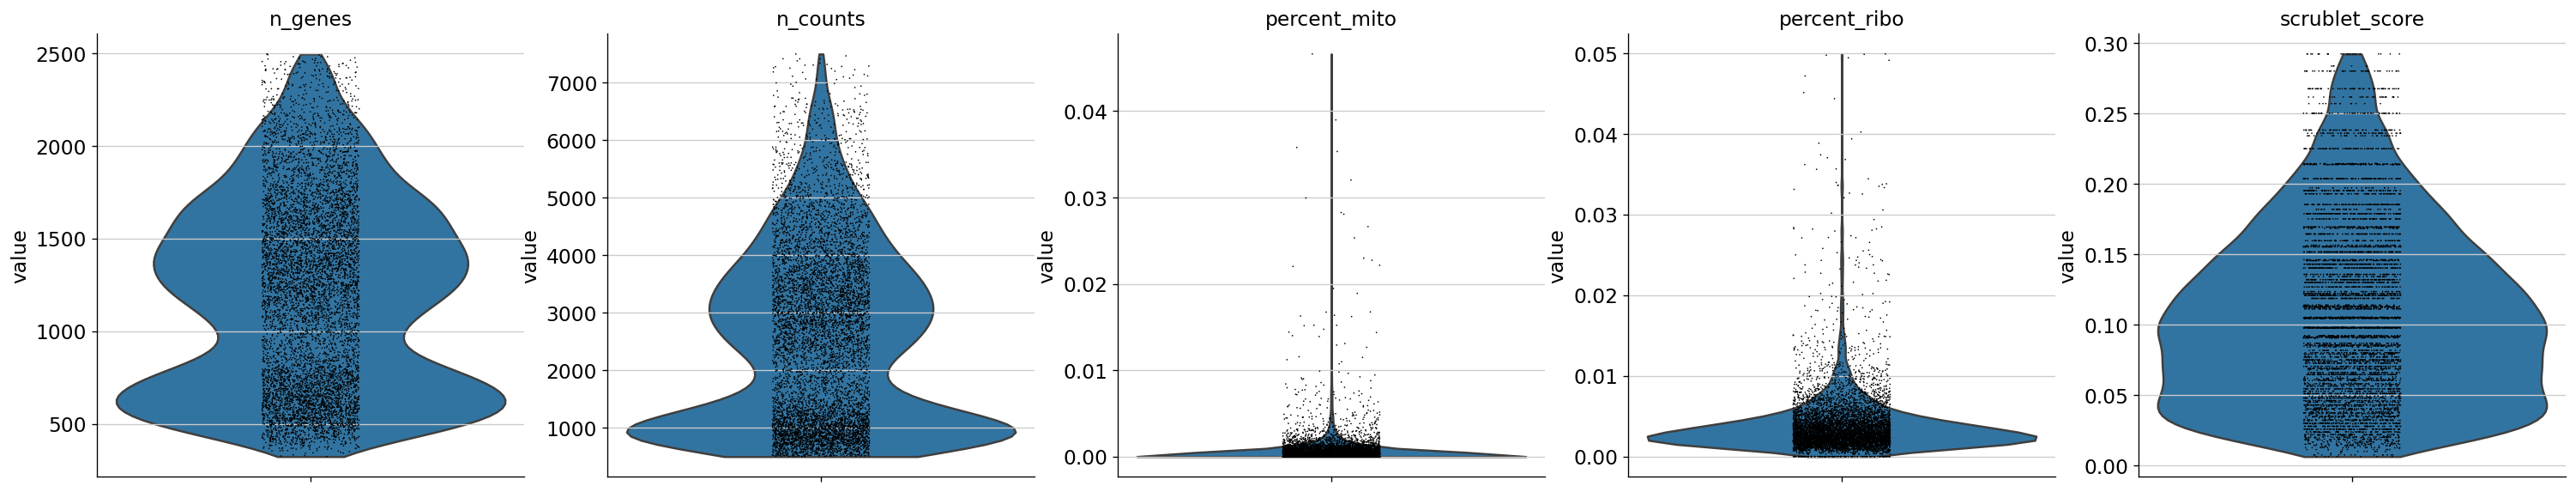

In [96]:
# QC plots after filtering
sc.pl.violin(fish_ven_merged_filtered, ['n_genes', 'n_counts', 'percent_mito','percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True)

In [97]:
print('Number of cells before filtering: ' + str(fish_ven_merged.shape[0]))
print('Number of genes before filtering: ' + str(fish_ven_merged.shape[1]))

Number of cells before filtering: 8538
Number of genes before filtering: 25107


In [98]:
print('Number of cells after filtering: ' + str(fish_ven_merged_filtered.shape[0]))
print('Number of genes after filtering: ' + str(fish_ven_merged_filtered.shape[1]))

Number of cells after filtering: 7422
Number of genes after filtering: 25107


In [99]:
fish_ven_merged.obs['genotype'].value_counts()

wildtype       4621
popdc1 null    3917
Name: genotype, dtype: int64

In [100]:
fish_ven_merged_filtered.obs['genotype'].value_counts()

wildtype       4120
popdc1 null    3302
Name: genotype, dtype: int64

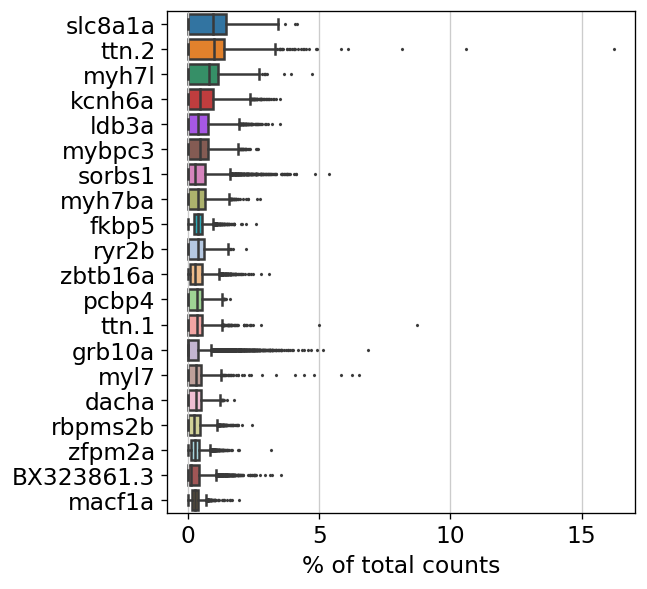

In [101]:
sc.pl.highest_expr_genes(fish_ven_merged, n_top=20)

/rds/general/user/lb616/home/anaconda3/envs/scanpy2/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


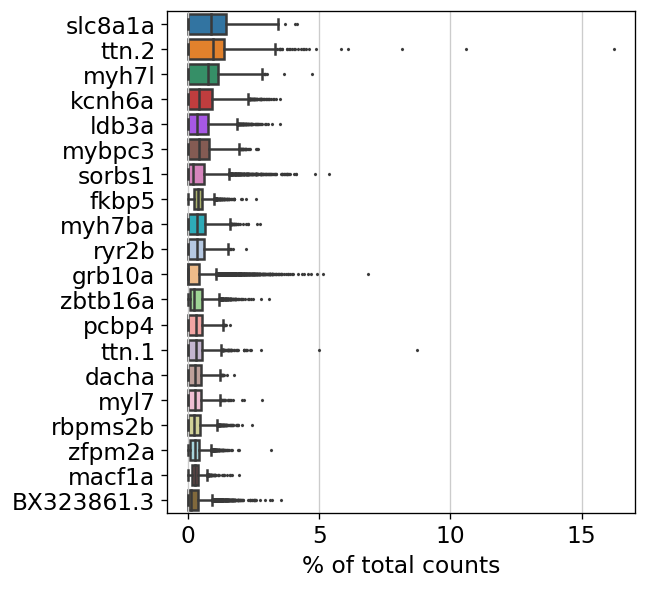

In [102]:
sc.pl.highest_expr_genes(fish_ven_merged_filtered, n_top=20)

In [103]:
fish_ven_merged_filtered.write('./fish_ven_filtered_089042021.h5ad')